In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("machinefale1.csv", usecols=[2,3,5,6,7,8,9,10,11,12])

# 「HDF」「PWF」「OSF」が「1」の行を削除
df = df[df["HDF"] != 1]
df = df[df["PWF"] != 1]
df = df[df["OSF"] != 1]
df

,Type,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF
0,M,298.1,1551,42.8,0,0,0,0,0,0
1,L,298.2,1408,46.3,3,0,0,0,0,0
2,L,298.1,1498,49.4,5,0,0,0,0,0
3,L,298.2,1433,39.5,7,0,0,0,0,0
4,L,298.2,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9986,M,298.8,1604,29.5,14,0,0,0,0,0
9987,H,298.9,1632,31.8,17,0,0,0,0,0
9988,M,299.0,1645,33.4,22,0,0,0,0,0
9989,H,299.0,1408,48.5,25,0,0,0,0,0


In [7]:
# 利用する列のみ抽出
df = df.iloc[:,:6]
df

,Type,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,1551,42.8,0,0
1,L,298.2,1408,46.3,3,0
2,L,298.1,1498,49.4,5,0
3,L,298.2,1433,39.5,7,0
4,L,298.2,1408,40.0,9,0
...,...,...,...,...,...,...
9986,M,298.8,1604,29.5,14,0
9987,H,298.9,1632,31.8,17,0
9988,M,299.0,1645,33.4,22,0
9989,H,299.0,1408,48.5,25,0


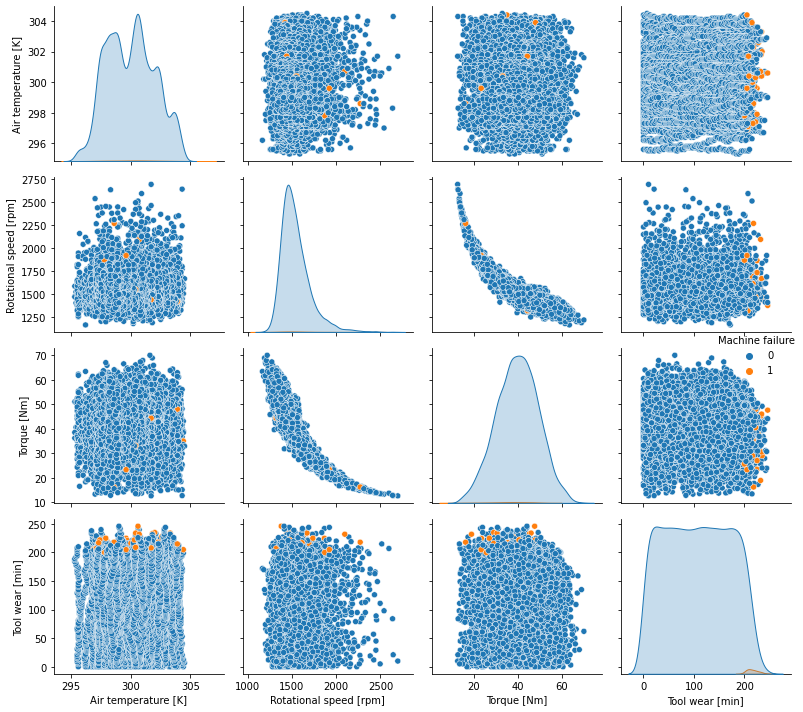

In [8]:
# ヒストグラム、散布図一括表示
sns.pairplot(df,hue="Machine failure")
plt.tight_layout()
plt.show()


In [9]:
# ラベル列を先頭に移動
first_column = df.pop('Machine failure')
df.insert(0,'Machine failure',first_column)

# 次元削減
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
df_pca = df.iloc[:,2:4]
df_pca = pca.fit_transform(df_pca)
df_pca = pd.DataFrame(df_pca,columns = ["pca"])
df_pca

# Type列をOne-hot-Encoding
df = pd.get_dummies(df,drop_first=True)
df = df.reset_index(drop = True)
df_a = df.iloc[:,:2]
df_b = df.iloc[:,4:]
df = pd.concat([df_a,df_pca,df_b], axis=1)

# 正規分布の列に標準化を適用
from sklearn import preprocessing
df['Air temperature [K]']=preprocessing.scale(df['Air temperature [K]'])
df['pca']=preprocessing.scale(df['pca'])
df


,Machine failure,Air temperature [K],pca,Tool wear [min],Type_L,Type_M
0,0,-0.943434,0.064219,0,0,1
1,0,-0.893203,-0.789120,3,1,0
2,0,-0.943434,-0.252054,5,1,0
3,0,-0.893203,-0.639935,7,1,0
4,0,-0.893203,-0.789120,9,1,0
...,...,...,...,...,...,...
9711,0,-0.591815,0.380493,14,0,1
9712,0,-0.541584,0.547581,17,0,0
9713,0,-0.491353,0.625157,22,0,1
9714,0,-0.491353,-0.789118,25,0,0


## 機械学習を実行しよう

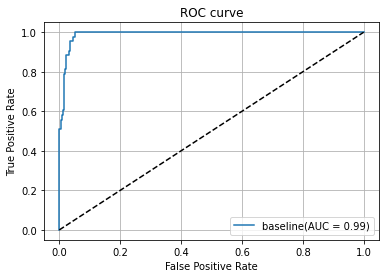

In [10]:
# 正常値のみの学習データ、正常値、異常値を合わせたテストデータを用意
# 正常値のトレーニングデータ、テストデータ
normal = df[df["Machine failure"] != 1]
x_normal = normal.iloc[:,1:]
y_normal = normal.iloc[:,0]

p = 300
x_test_normal = x_normal.iloc[:p, :]
y_test_normal = y_normal.iloc[:p]
x_train_normal = x_normal.iloc[p:, :]

# 異常値のテストデータ
outliers = df[df["Machine failure"] != 0]
x_test_outliers = outliers.iloc[:,1:]
y_outliers = outliers.iloc[:,0]

# 正常値、異常値を合わせたテストデータ
x_test = pd.concat([x_test_normal, x_test_outliers])

# テストデータのラベルリスト
y_test = pd.concat([y_test_normal, y_outliers])

# 学習
from sklearn import svm
from sklearn.svm import OneClassSVM
# fit the model
clf = OneClassSVM(nu=0.01, kernel='linear', gamma=0.1)
# kernel種類：'linear'、 'poly'、 'rbf'、 'sigmoid'
clf.fit(x_train_normal)

y_pred = clf.predict(x_test)

# 可視化
from sklearn import svm
y_score = clf.decision_function(x_test)
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test,y_score)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.plot(fpr, tpr, label='baseline(AUC = %.2f)'%auc)
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()